In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sys
# import booleanNetwork module from ./src
from BNMPy import booleanNetwork as bn
from BNMPy import BMatrix  

## Loading model

In [2]:
file = 'input_files/dnmt3a_equations.txt'

In [3]:
with open(file) as f:
    file_data = f.read()

In [4]:
network = BMatrix.load_network_from_string(file_data)

No initial state provided, using a random initial state


In [34]:
network

## Mutations

In [5]:
mutations = [['FLT3'], ['NPM1'], ['DNMT3A'], ['FLT3', 'NPM1'], ['FLT3', 'DNMT3A'], ['NPM1', 'DNMT3A'], ['FLT3', 'NPM1', 'DNMT3A']]
directions = {'FLT3': 1, 'NPM1': 0, 'DNMT3A': 0}

In [36]:
mutation_results = {}
for mutation in mutations:
    network.undoKnockouts()
    network.setInitialValue('FLT3', 0)
    network.setInitialValue('NPM1', 1)
    network.setInitialValue('DNMT3A', 1)
    for g in mutation:
        network.knockout(g, directions[g])
    results = network.update(20)
    results = results[-1, :]
    results = {k: results[v] for k, v in network.nodeDict.items()}
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['MYC'] + results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']

    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    print('_'.join(mutation), results['PROLIFERATION'], results['DIFFERENTIATION'], results['APOPTOSIS'], results['NETWORK'])
    mutation_results['_'.join(mutation)] = results

FLT3 2 0 1 1
NPM1 1 1 0 0
DNMT3A 1 1 1 -1
FLT3_NPM1 4 -1 -1 6
FLT3_DNMT3A 4 -1 1 4
NPM1_DNMT3A 1 1 0 0
FLT3_NPM1_DNMT3A 5 -1 -1 7


## Wild-type

In [7]:
# 3 inputs: FLT3, DNMT3A, NPM1
# wild-type
network.undoKnockouts()
network.setInitialValue('FLT3', 0)
network.setInitialValue('NPM1', 1)
network.setInitialValue('DNMT3A', 1)
results = network.update(20)
results = results[-1, :]
results = {k: results[v] for k, v in network.nodeDict.items()}

In [8]:
results['APOPTOSIS'] = results['TP53'] - results['BCL2']
results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
results['PROLIFERATION'] = results['MYC'] + results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']

# calculate the network scores
results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']

In [9]:
print(results['APOPTOSIS'], results['DIFFERENTIATION'], results['PROLIFERATION'], results['NETWORK'])
mutation_results['WT'] = results

1 2 0 -3


## Loading clinical data

see: https://github.com/IlyaLab/LogicModelMerger/blob/main/Reproducing%20selected%20models/Palma2021/Palma2021.ipynb

Data sources

In [10]:
# Data file path
tsv_file_path_genes = 'https://api.gdc.cancer.gov/data/0d8851d7-1af0-4054-a527-5db763138400'
tsv_file_path_clinical = 'https://api.gdc.cancer.gov/data/1fd61a91-90d5-405a-bcef-b9df8b396a21'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# clinical data 
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'lab_procedure_blast_cell_outcome_percentage_value',
                                                            'lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

# Function to determine mutation combination
def determine_combination(row):
    genes = row['gene_name']
    has_flt3 = 'FLT3' in genes
    has_npm1 = 'NPM1' in genes
    has_dnmt3a = 'DNMT3A' in genes

    if has_flt3 and has_npm1 and has_dnmt3a:
        return "flt3_npm1_dnmt3a"
    elif has_flt3 and has_dnmt3a:
        return "flt3_dnmt3a"
    elif has_flt3 and has_npm1:
        return "flt3_npm1"
    elif has_npm1 and has_dnmt3a:
        return "npm1_dnmt3a"
    elif has_flt3:
        return "flt3"
    elif has_npm1:
        return "npm1"
    elif has_dnmt3a:
        return "dnmt3a"
    else:
        return "wt"

# Group by TCGA_id and apply the combination function
grouped = df_genes.groupby('TCGA_id').agg(list).reset_index()
grouped['mutation'] = grouped.apply(determine_combination, axis=1)

# Merge the gene information with the clinical data
clinical_result = pd.merge(df_clinical, grouped[['TCGA_id', 'mutation']], left_on='bcr_patient_barcode', right_on='TCGA_id')
clinical_result = clinical_result[['TCGA_id', 'mutation', 
                   'lab_procedure_blast_cell_outcome_percentage_value',
                   'lab_procedure_bone_marrow_blast_cell_outcome_percent_value']]

print(clinical_result)

          TCGA_id     mutation  \
0    TCGA-AB-2802  npm1_dnmt3a   
1    TCGA-AB-2803           wt   
2    TCGA-AB-2804           wt   
3    TCGA-AB-2805           wt   
4    TCGA-AB-2806           wt   
..            ...          ...   
192  TCGA-AB-3007         flt3   
193  TCGA-AB-3008           wt   
194  TCGA-AB-3009           wt   
195  TCGA-AB-3011         npm1   
196  TCGA-AB-3012           wt   

     lab_procedure_blast_cell_outcome_percentage_value  \
0                                                   88   
1                                                   44   
2                                                   82   
3                                                   67   
4                                                   90   
..                                                 ...   
192                                                 90   
193                                                 71   
194                                                 51   
195        

In [11]:
clinical_result

,TCGA_id,mutation,lab_procedure_blast_cell_outcome_percentage_value,lab_procedure_bone_marrow_blast_cell_outcome_percent_value
0,TCGA-AB-2802,npm1_dnmt3a,88,52
1,TCGA-AB-2803,wt,44,0
2,TCGA-AB-2804,wt,82,6
3,TCGA-AB-2805,wt,67,56
4,TCGA-AB-2806,wt,90,81
...,...,...,...,...
192,TCGA-AB-3007,flt3,90,7
193,TCGA-AB-3008,wt,71,90
194,TCGA-AB-3009,wt,51,63
195,TCGA-AB-3011,npm1,91,83


In [12]:
from io import StringIO
hazards_data = StringIO("""wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a
1,1.4,0.7,1.1,1,1.2,1.1,1.5""")
hazard_ratios = pd.read_csv(hazards_data)

In [13]:
hazard_ratios

,wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a
0,1,1.4,0.7,1.1,1,1.2,1.1,1.5


In [14]:
hazard_ratios = hazard_ratios.T

## Comparing model network scores with clinical data

In [15]:
clinical_result['apoptosis'] = [mutation_results[r['mutation'].upper()]['APOPTOSIS'] for k, r in clinical_result.iterrows()]

In [16]:
clinical_result['differentiation'] = [mutation_results[r['mutation'].upper()]['DIFFERENTIATION'] for k, r in clinical_result.iterrows()]

In [17]:
clinical_result['proliferation'] = [mutation_results[r['mutation'].upper()]['PROLIFERATION'] for k, r in clinical_result.iterrows()]

In [18]:
clinical_result['network_score'] = [mutation_results[r['mutation'].upper()]['NETWORK'] for k, r in clinical_result.iterrows()]

In [19]:
import matplotlib.pyplot as plt

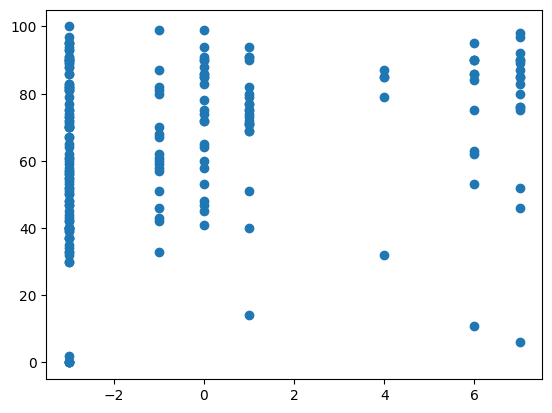

In [20]:
plt.scatter(clinical_result['network_score'], clinical_result['lab_procedure_blast_cell_outcome_percentage_value'])

In [21]:
median_blasts = clinical_result.groupby('mutation')[['network_score', 'lab_procedure_blast_cell_outcome_percentage_value', 'lab_procedure_bone_marrow_blast_cell_outcome_percent_value']].agg('median')

In [22]:
median_blasts

,network_score,lab_procedure_blast_cell_outcome_percentage_value,lab_procedure_bone_marrow_blast_cell_outcome_percent_value
mutation,,,
dnmt3a,-1.0,61.0,32.0
flt3,1.0,74.5,54.0
flt3_dnmt3a,4.0,85.0,32.0
flt3_npm1,6.0,85.0,45.0
flt3_npm1_dnmt3a,7.0,85.0,49.0
npm1,0.0,84.0,67.5
npm1_dnmt3a,0.0,72.0,17.0
wt,-3.0,61.0,17.0


In [23]:
mean_blasts = clinical_result.groupby('mutation')[['network_score', 'lab_procedure_blast_cell_outcome_percentage_value', 'lab_procedure_bone_marrow_blast_cell_outcome_percent_value']].agg('mean')

In [24]:
mean_blasts

,network_score,lab_procedure_blast_cell_outcome_percentage_value,lab_procedure_bone_marrow_blast_cell_outcome_percent_value
mutation,,,
dnmt3a,-1.0,63.473684,33.421053
flt3,1.0,72.090909,44.681818
flt3_dnmt3a,4.0,73.600000,48.000000
flt3_npm1,6.0,73.750000,46.166667
flt3_npm1_dnmt3a,7.0,76.882353,44.176471
npm1,0.0,76.500000,53.714286
npm1_dnmt3a,0.0,68.909091,31.636364
wt,-3.0,60.329897,29.061856


### Network scores vs mean/median blast percentages

In [25]:
import scipy.stats

In [26]:
scipy.stats.pearsonr(mean_blasts['network_score'], mean_blasts['lab_procedure_blast_cell_outcome_percentage_value'])

PearsonRResult(statistic=0.7573812385041419, pvalue=0.02952215317802802)

In [27]:
scipy.stats.pearsonr(mean_blasts['network_score'], mean_blasts['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

PearsonRResult(statistic=0.5633160924515667, pvalue=0.1459539862615835)

In [28]:
scipy.stats.pearsonr(median_blasts['network_score'], median_blasts['lab_procedure_blast_cell_outcome_percentage_value'])

PearsonRResult(statistic=0.8154310250207597, pvalue=0.013623115858969002)

In [29]:
scipy.stats.pearsonr(median_blasts['network_score'], median_blasts['lab_procedure_bone_marrow_blast_cell_outcome_percent_value'])

PearsonRResult(statistic=0.36911148454798703, pvalue=0.36820784426007336)

Text(0, 0.5, 'Median blast percentage')

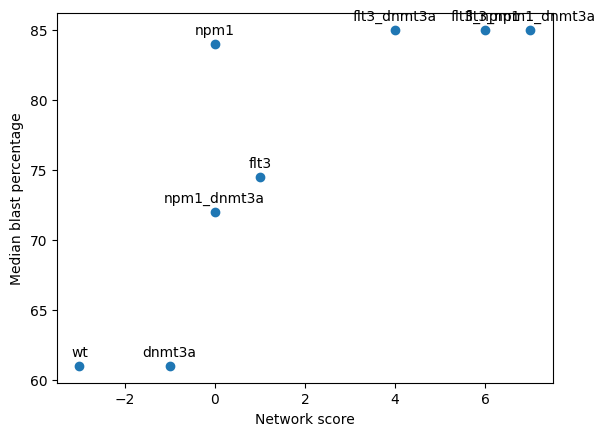

In [30]:
fig, ax = plt.subplots()
ax.scatter(median_blasts['network_score'], median_blasts['lab_procedure_blast_cell_outcome_percentage_value'])
for i, row in median_blasts.iterrows():
    ax.annotate(i, (row['network_score'], row['lab_procedure_blast_cell_outcome_percentage_value']), textcoords="offset points", xytext=(0,7), ha='center')
plt.xlabel('Network score')
plt.ylabel('Median blast percentage')

Text(0.5, 0, 'Median blast percentage')

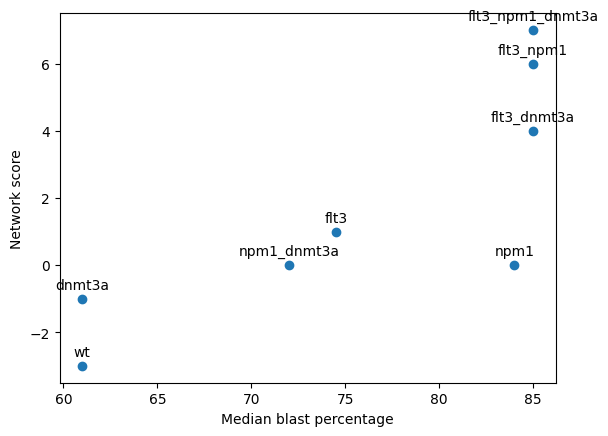

In [35]:
fig, ax = plt.subplots()
ax.scatter(median_blasts['lab_procedure_blast_cell_outcome_percentage_value'], median_blasts['network_score'])
for i, row in median_blasts.iterrows():
    ax.annotate(i, (row['lab_procedure_blast_cell_outcome_percentage_value'], row['network_score']), textcoords="offset points", xytext=(0,7), ha='center')
plt.ylabel('Network score')
plt.xlabel('Median blast percentage')

### Network scores vs survival

In [31]:
hazard_ratios['apoptosis'] = [mutation_results[k.upper()]['APOPTOSIS'] for k, r in hazard_ratios.iterrows()]

hazard_ratios['differentiation'] = [mutation_results[k.upper()]['DIFFERENTIATION'] for k, r in hazard_ratios.iterrows()]

hazard_ratios['proliferation'] = [mutation_results[k.upper()]['PROLIFERATION'] for k, r in hazard_ratios.iterrows()]

hazard_ratios['network_score'] = [mutation_results[k.upper()]['NETWORK'] for k, r in hazard_ratios.iterrows()]

In [32]:
scipy.stats.pearsonr(hazard_ratios['network_score'], hazard_ratios[0])

PearsonRResult(statistic=0.5592042199464444, pvalue=0.149571460729892)

Text(0, 0.5, 'Hazard Ratio')

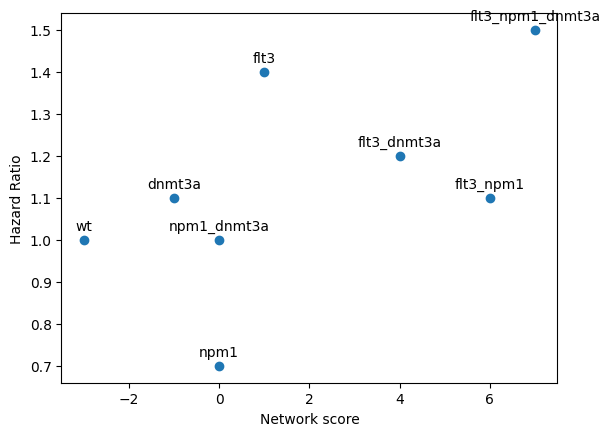

In [33]:
fig, ax = plt.subplots()
ax.scatter(hazard_ratios['network_score'], hazard_ratios[0])
for i, row in hazard_ratios.iterrows():
    ax.annotate(i, (row['network_score'], row[0]), textcoords="offset points", xytext=(0,7), ha='center')
plt.xlabel('Network score')
plt.ylabel('Hazard Ratio')